<a href="https://colab.research.google.com/github/nyculescu/kaggle__competitive_data_science_predict_future_sales/blob/master/01_kernel_nb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

### Input files

* shops.csv- supplemental information about the shops -- `61 entries`
    * shop_name (e.g., "СПб ТК ""Сенная""")
    * shop_id (e.g., 43)

* item_categories.csv  - supplemental information about the items categories -- `85 entries`
    * item_category_name (e.g., Кино - DVD)
    * item_category_id (e.g., 40)

* items.csv - supplemental information about the items/products -- `22.171 entries`
    * item_name (e.g., 1812: 4 СЕРИИ (регион))
    * item_id (e.g., 97)
    * item_category_id (e.g., 40)

* sales_train.csv - the training set. Daily historical data from January 2013 to October 2015 -- `2.935.850 entries | 587.170 entries should be allotted to the training set`
    * <strike>date (e.g., 23.02.2013)</strike> *I don't see the reason of using this in ML training because we already have date_block_num as an attribute*
    * date_block_num (e.g., 1)
    * shop_id (e.g., 43) - `shop_id and item_id shall be concatenated to ID`
    * item_id (e.g., 97) - `shop_id and item_id shall be concatenated to ID`
    * item_price (e.g., 149.0)
    * item_cnt_day (e.g., 1.0)

* sample_submission.csv - a sample submission file in the correct format -- `214.201 entries`
    * ID (e.g., 0)
    * item_cnt_month (e.g., 0.5)

* test.csv - the test set. You need to forecast the sales for these shops and products for November 2015 -- `214.201 entries`
    * ID (e.g., 0)
    * shop_id (e.g., 43)
    * item_id (e.g., 97)


### Data fields
* ID - an Id that represents a (Shop, Item) tuple within the test set
* shop_id - unique identifier of a shop
* item_id - unique identifier of a product
* item_category_id - unique identifier of item category
* item_cnt_day - number of products sold. You are predicting a monthly amount of this measure
* item_price - current price of an item
* date - date in format dd/mm/yyyy
* date_block_num - a consecutive month number, used for convenience. January 2013 is 0, February 2013 is 1,..., October 2015 is 33
* item_name - name of item
* shop_name - name of shop
* item_category_name - name of item category

### The objective: what needs to be done?
The task is to forecast the total amount of products sold in every shop for the test set.

! Note that the list of shops and products slightly changes every month.


### Frame this problem
* typical supervised learning task - we have the labeled training examples
* typical regression task - we're asked to predict a value
    * multiple regression problem (value prediction) - the system will use multiple features to make a prediction
    * also univariate regression problem - we're only trying to predict a single value (*total amount of products sold*) in every *shop*
* plain batch learning - we don't have a continuous flow of data coming to the system - the data doesn't need to be adjusted rapidly, and the data is small enoug to fit in memory (`is it so?`)

---
# Get the data & Discover and visualize the data to gain insights

---
## Setup

In [0]:
### run ###

# Python ≥3.5 is required
import sys
assert sys.version_info >= (3, 5)

# Scikit-Learn ≥0.20 is required
import sklearn
assert sklearn.__version__ >= "0.20"

# Common imports
import numpy as np
import os
import csv
import pandas as pd

# To plot pretty figures
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Where to save the figures
PROJECT_ROOT_DIR = "."
CHAPTER_ID = "kaggle__competitive_data_science_predict_future_sales"
IMAGES_PATH = os.path.join(PROJECT_ROOT_DIR, "images", CHAPTER_ID)
os.makedirs(IMAGES_PATH, exist_ok=True)

def save_fig(fig_id, tight_layout=True, fig_extension="png", resolution=300):
    path = os.path.join(IMAGES_PATH, fig_id + "." + fig_extension)
    print("Saving figure", fig_id)
    if tight_layout:
        plt.tight_layout()
    plt.savefig(path, format=fig_extension, dpi=resolution)

# Ignore useless warnings (see SciPy issue #5998)
import warnings
warnings.filterwarnings(action="ignore", message="^internal gelsd")

---
### Colab

In [2]:
from google.colab import drive
drive.mount('/content/drive')

sales_train = pd.read_csv('drive/My Drive/Colab Notebooks/datasets/sales_train.csv')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


---
### VS Code

In [0]:
sales_train = pd.read_csv(os.path.abspath(os.path.join('input', 'sales_train.csv')))

---
## Analyze the data added

In [0]:
sales_train.head()
sales_train.head(-5)

In [0]:
sales_train.info()

In [0]:
# see the amount of memory used (in bytes) for each column. 
# It’s useful when building machine learning models which may require a lot memory in training.
sales_train.memory_usage(deep=True)

We can find out what categories exist and how many districts belong to each category by using the value_counts() method, but we know them already (form the description)

In [0]:
## Var 1
# For numeric data, the result’s index will include count, mean, std, min, max as well as lower, 50 and upper percentiles.
# For object data (e.g. strings or timestamps), the result’s index will include count, unique, top, and freq. The top is the most common value. The freq is the most common value’s frequency. Timestamps also include the first and last items.

sales_train.describe(include='all')

In [0]:
### run ###

# the "date" field doesn't look to be relevant, so drop it
sales_train.drop("date", axis=1, inplace=True)

In [0]:
### run ###

## Var 2 - print the entire number in Python from describe() function, but only for the numeric data

def describe_entire_nrs(datafr):
    desc = datafr.describe() # include='all' will not work
    desc.loc['count'] = desc.loc['count'].astype(int).astype(str)
    desc.iloc[1:] = desc.iloc[1:].applymap('{:.2f}'.format)
    return desc

In [15]:
describe_entire_nrs(sales_train)

,date_block_num,shop_id,item_id,item_price,item_cnt_day
count,2935849,2935849,2935849,2935849,2935849
mean,14.57,33.00,10197.23,890.85,1.24
std,9.42,16.23,6324.30,1729.80,2.62
min,0.00,0.00,0.00,-1.00,-22.00
25%,7.00,22.00,4476.00,249.00,1.00
50%,14.00,31.00,9343.00,399.00,1.00
75%,23.00,47.00,15684.00,999.00,1.00
max,33.00,59.00,22169.00,307980.00,2169.00


There are values below 0 for item_cnt_day and item_price -- I don't see any reason, so I will not consider these values and delete the whole row which contains them.

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f13062d1518>,
      dtype=object)

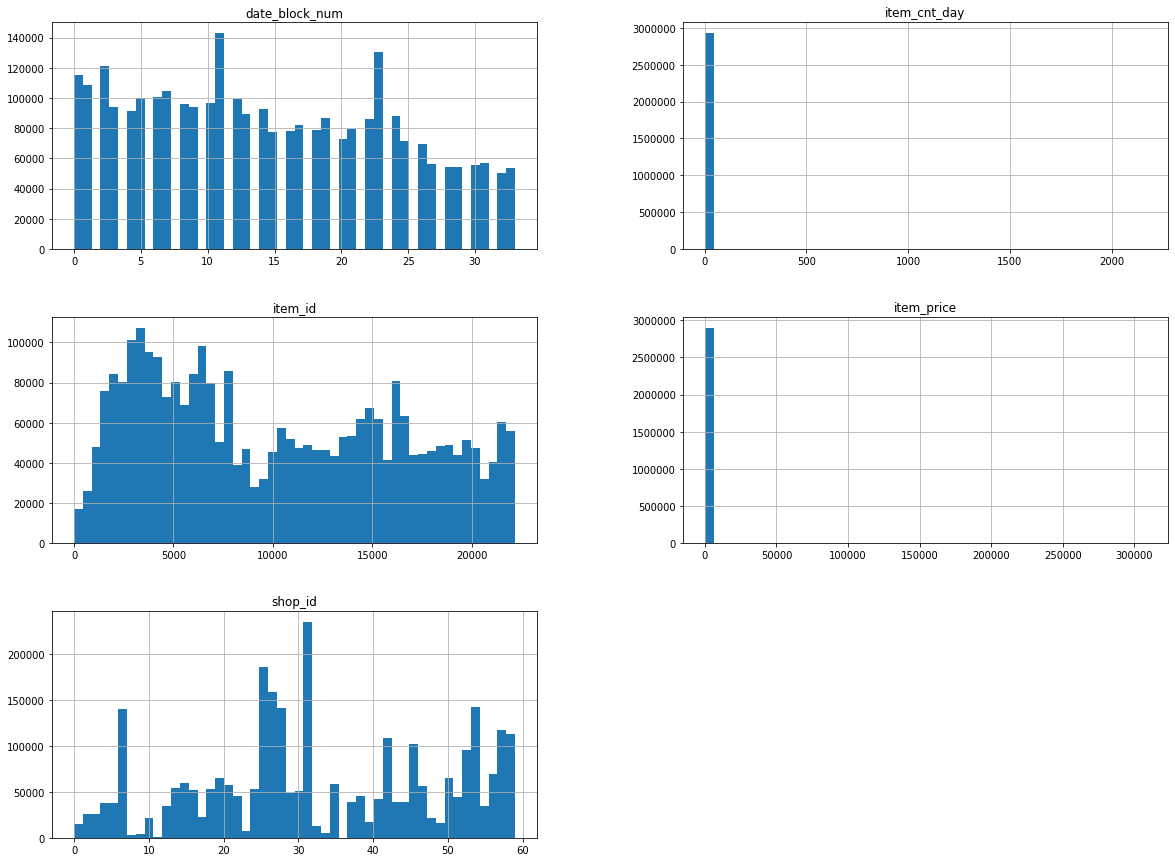

In [0]:
sales_train.hist(bins=50, figsize=(20,15))
# plt.show()

observations on th plotted dataframe:
* date_block_num, item_id, shop_id are capped -- Warning from hands-on book: The latter may be a serious problem since it is your target attribute (your labels). Your Machine Learning algorithms may learn that prices never go beyond that limit.
    * date_block_num even capped, doesn't look to be a problem
* These attributes have very different scales
* item_cnt_day and item_price don't express anything


---
#### Looking for Correlations

In [0]:
corr_matrix = sales_train.corr()
corr_matrix["item_cnt_day"].sort_values(ascending=False)

In [0]:
attributes = ["date_block_num", "item_cnt_day", "item_price", "shop_id", "item_id"]
scatter_matrix(sales_train[attributes], figsize=(12, 8))

Some correlations found:
* date_block_num vs item_cnt_day - more and more items are sold
* date_block_num vs item_price - more and more expensive items are sold
* shop_id vs item_cnt_day - determine which shops sell more to less
* item_id vs item_cnt_day - determine which items are the most sold

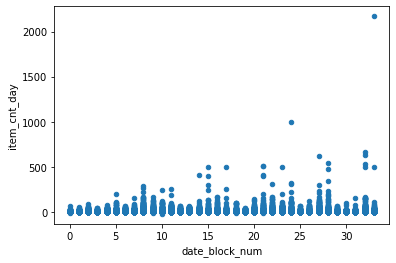

In [5]:
sales_train.plot(kind="scatter", x="date_block_num", y="item_cnt_day")

In [47]:
# Find max value & its index of the shop_id, then print them

# cnt_i = [0] * (sales_train_outl_1shop["shop_id"].max() + 1)
# for i in sales_train_outl_1shop["shop_id"]:
#     cnt_i[i] += 1

# cnt_i_max = np.where(cnt_i == np.amax(cnt_i))[0]
# print("max value: ", cnt_i_max, np.amax(cnt_i))

max value:  [31] 235634


In [0]:
# describe_entire_nrs(sales_train_outl_1shop)

In [0]:
# sales_train_outl_1shop = sales_train_outl_1shop[sales_train_outl_1shop["shop_id"] == cnt_i_max[0]] # drop te rows which doesn't have the shop_id equal to cnt_i_max
# sales_train_outl_mdl = sales_train_outl_1shop.copy()

In [0]:
# sales_train_outl = sales_train[~(sales_train['item_cnt_day'] > 650)] # ignore the outliers
# sales_train_outl = sales_train_outl[~(sales_train_outl['item_cnt_day'] < -1)] # ignore the outliers
# sales_train_outl.plot(kind="scatter", x="date_block_num", y="item_cnt_day")
# sales_train_outl_mdl = sales_train_outl.copy()

### This is not needed due to feature scaling

---
## Compute a test set

In [0]:
### run ###

from zlib import crc32

def test_set_check(identifier, test_ratio):
    return crc32(np.int64(identifier)) & 0xffffffff < test_ratio * 2**32

def split_train_test_by_id(data, test_ratio, id_column):
    ids = data[id_column]
    in_test_set = ids.apply(lambda id_: test_set_check(id_, test_ratio))
    return data.loc[~in_test_set], data.loc[in_test_set]

In [0]:
sales_train_with_id = sales_train.reset_index()   # adds an `index` column
train_set, test_set = split_train_test_by_id(sales_train_with_id, 0.2, "index")

---
# Prepare the data for Machine Learning algorithms

In [0]:
# cleanup the rows which have the item_cnt_day and item_price with negative values
sales_train = sales_train[~(sales_train['item_cnt_day'] < 0)]
sales_train = sales_train[~(sales_train['item_price'] < 0)]

In [0]:
housing = strat_train_set.drop("median_house_value", axis=1) # drop labels for training set
housing_labels = strat_train_set["median_house_value"].copy()

### Preprocess the categorical input features, **item_id** and **shop_id**

In [0]:
from sklearn.preprocessing import OneHotEncoder

item_cat_1hot = OneHotEncoder().fit_transform(sales_train[["item_id"]])
# print(item_cat_1hot)

In [0]:
shop_cat_1hot = OneHotEncoder().fit_transform(sales_train[["shop_id"]])
# print(shop_cat_1hot)

In [0]:
sales_train_num = sales_train.drop({"item_id", "shop_id"}, axis=1)

---
### <strike>Add extra attr</strike>
I'm thinking to create a custom transformer to add extra attributes, but it's postponed for now

---
### Build a pipeline for preprocessing the numerical attributes

In [0]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer

num_pipeline = Pipeline([
        ('imputer', SimpleImputer(strategy="median")),
        # ('attribs_adder', CombinedAttributesAdder()),
        ('std_scaler', StandardScaler()),
    ])

# sales_train_num_tr = num_pipeline.fit_transform(sales_train_num)

In version 0.20, Scikit-Learn introduced the ColumnTransformer to have a single transformer able to handle all columns -- to avoid handle the categorical columns and the numerical columns separately


In [0]:
from sklearn.compose import ColumnTransformer

num_attribs = list(sales_train_num)
item_attribs = ["item_id"]
shop_attribs = ["shop_id"]

full_pipeline = ColumnTransformer([
        ("num", num_pipeline, num_attribs),
        ("itm", OneHotEncoder(), item_attribs),
        ("shp", OneHotEncoder(), shop_attribs)
    ])

sales_train_prepared = full_pipeline.fit_transform(sales_train)

Here is how this works: first we import the ColumnTransformer class, next we get the list of numerical column names and the list of categorical column names, and we construct a ColumnTransformer. The constructor requires a list of tuples, where each tuple contains a name, a transformer and a list of names (or indices) of columns that the transformer should be applied to. 

In this example, we specify that the numerical columns should be transformed using the num_pipeline that we defined earlier, and the categorical columns should be transformed using a OneHotEncoder. 

Finally, we apply this ColumnTransformer to the **sales_train** data: it applies each transformer to the appropriate columns and concatenates the outputs along the second axis (the transformers must return the same number of rows).

---
# The model

In [0]:
### this is a draft

# lin1 = sklearn.linear_model.LinearRegression()

# Xsample1 = np.c_[sales_train_mdl["date_block_num"]]
# ysample1 = np.c_[sales_train_mdl["item_cnt_day"]]
# lin1.fit(Xsample1, ysample1)
# t0 = lin1.intercept_[0]
# t1 = lin1.coef_[0][0]

# sales_train_mdl.plot(kind='scatter', x="date_block_num", y='item_cnt_day')
# y = np.linspace(sales_train_mdl["date_block_num"].min(), sales_train_mdl["date_block_num"].max())
# # plt.plot(y, t0 + t1*y, "r+", alpha=1) # the trend is not visible if it's plotted here

In [0]:
### this is a draft

# plt.plot(y, t0 + t1*y, "r+") # this describes a linear trend

In [0]:
from sklearn.linear_model import LinearRegression

sales_train_prepared_labels = sales_train_prepared["item_cnt_day"].copy() # item_cnt_day is a predictor
housing = strat_train_set.drop("median_house_value", axis=1)

lin_reg = LinearRegression()
lin_reg.fit(sales_train_prepared, sales_train_prepared_labels)

---
the other data from the CSVs &darr;

In [0]:
item_categories = pd.read_csv(os.path.abspath(os.path.join('input', 'item_categories.csv')))
items = pd.read_csv(os.path.abspath(os.path.join('input', 'items.csv')))
sample_submission = pd.read_csv(os.path.abspath(os.path.join('input', 'sample_submission.csv')))
shops = pd.read_csv(os.path.abspath(os.path.join('input', 'shops.csv')))
test = pd.read_csv(os.path.abspath(os.path.join('input', 'test.csv')))

In [0]:
item_categories.info()
item_categories.describe(include='all')

In [0]:
items.info()
items.describe(include='all')

In [0]:
sample_submission.info()
sample_submission.describe(include='all')

In [0]:
shops.info()
shops.describe(include='all')

In [0]:
test.info()
test.describe(include='all')

---
the other data from the CSVs &uarr;

In [0]:
train_set.info()

In [0]:
# train_set.plot(kind="scatter", x="date_block_num", y="item_cnt_day")

# -- or --
plt.scatter(train_set["date_block_num"], train_set["item_cnt_day"]) # in the notebook this gets stuck...
plt.show()

Select a Performance Measure -- A typical performance measure for regression problems is the Root Mean Square Error (RMSE). It gives an idea of how much error the system typically makes in its predictions, with a higher weight for large errors.

`todo`